In [7]:
%matplotlib inline
import json
from collections import OrderedDict

import pandas as pd
import sqlite3
import networkx as nx

In [8]:
# read node data from database
engine = sqlite3.connect('../db.sqlite3')
node_df = pd.read_sql('SELECT * FROM node_information', engine, index_col='nodeId')
node_df['linkedNode'] = node_df['linkedNode'].apply(lambda x : json.loads(x)) # json to list

print(node_df.loc[1400020900, 'linkedNode'])
print(node_df.loc[1400021000, 'linkedNode'])

[1400020800]
[1400020600, 1400020800, 1400020900]


In [9]:
# list1 요소가 모두 list2에 있으면 True 반환
def includelist(list1, list2):
    set_list1 = set(list1)
    set_list2 = set(list2)
    return len(set_list1 - set_list2) <= 1

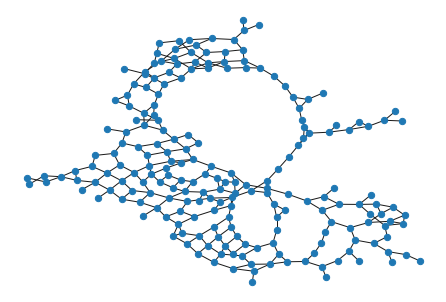

In [10]:
# 금정구의 도로 데이터를 이용하여 그린 전체 그래프
G = nx.Graph()

G.add_nodes_from(node_df.index)

for start_node in node_df.index:
    for end_node in node_df.loc[start_node, 'linkedNode']:
        G.add_edge(start_node, end_node)

nx.draw(G, nx.kamada_kawai_layout(G), with_labels=False, node_size=40) # edge의 길이를 비슷하게 하며, 교차하는 edge가 되도록이면 적게 있도록 설계

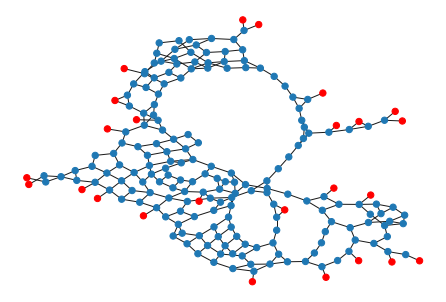

In [11]:
# corner인 node 색상을 빨간색으로 변경
color_map = []
corner_nodes = []

for cur_node in G:
    is_corner = False

    for linked_node in node_df.loc[cur_node, 'linkedNode']:
        if includelist(node_df.loc[cur_node, 'linkedNode'], node_df.loc[linked_node, 'linkedNode']):
            is_corner = True

    if is_corner:
        color_map.append('red')
        corner_nodes.append(cur_node)
    else:
        color_map.append('#1F78B4')

nx.draw(G, nx.kamada_kawai_layout(G), node_color=color_map, with_labels=False, node_size=40)

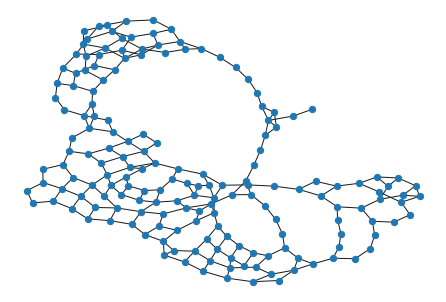

In [12]:
# corner node들 반복적으로 제거
while len(corner_nodes) > 0:
    for corner_node in corner_nodes:
        for corner_linked_node in node_df.loc[corner_node, 'linkedNode']:
            if corner_node in node_df.loc[corner_linked_node, 'linkedNode']:
                node_df.loc[corner_linked_node, 'linkedNode'].remove(corner_node)
        node_df = node_df.drop(index=corner_node)

    G.remove_nodes_from(corner_nodes)
    corner_nodes.clear()

    for cur_node in G:
        is_corner = False

        for linked_node in node_df.loc[cur_node, 'linkedNode']:
            if linked_node in node_df.index:
                if includelist(node_df.loc[cur_node, 'linkedNode'], node_df.loc[linked_node, 'linkedNode']):
                    is_corner = True

        if is_corner:
            corner_nodes.append(cur_node)

nx.draw(G, nx.kamada_kawai_layout(G), with_labels=False, node_size=40)